### Trabalho Final - Aprendizado de Máquina
- Vinícius Braga Freire - 2020054889

#### 0. Introdução

Neste projeto final iremos utilizar de todos conhecimentos obtidos durante o curso de `Aprendizado de Máquina` de forma que se produza um projeto estruturado e com resultados claros utilizando de ferramentas e técnicas aprendidas.

Neste projeto iremos trabalhar com um banco de dados `IMAGINE` da empresa `DEXCO`. Através desses dados iremos criar um modelo de tal forma que possamos avaliar se uma dada dupla de funcionários deveriam ou não trabalhar juntos em função do desempenho previsto. Este experimento poderia ser utilizado no projeto de super times da empresa de forma a gerar equipes com máximo desempenho, maximizando a produtividade da corporação.

Para este trabalho são necessários os seguintes pacotes: `numpy`, `pandas`, `scikit-learn`, `jolib`, `lightgbm` e `nbne`. Para este ultimo, não será possível utilizar a versão `pip` do `nbne`, pois esta está desatualizada em relação ao `numpy`. Para instalar o `nbne` mais recente é necessário executar o comando `pip` dentro desta [branch](https://github.com/jonasvilasboass/nbne/tree/master) aqui. Estarei disponibilizando na root do `.zip` enviado no `moodle` este arquivo, então basta executar a instrução à seguir que a versão corrigida do `nbne` será instalada. Somente lembre que depois de instalada é necessário reiniciar o kernel do `jupyter` para que o pacote esteja constando como instalado.

In [21]:
# !pip uninstall nbne # Pode ser que seja necessário apagar o nbne antigo para que o corrigido seja instalado
!pip install ./nbne
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Processing ./nbne
  Preparing metadata (setup.py) ... done
  Created wheel for nbne: filename=nbne-0.81-py3-none-any.whl size=5288 sha256=265a3a2c33a3d12b5ea6bed334cd1a3e49d0cc52d3524572580a73f1f29bb933
  Stored in directory: /tmp/pip-ephem-wheel-cache-743wo0k6/wheels/07/07/06/2de0b333b9579cb188a8c4e5f9cec20d3a61a5f357c35369ec
Successfully built nbne
  Attempting uninstall: nbne
    Found existing installation: nbne 0.81
    Uninstalling nbne-0.81:
      Successfully uninstalled nbne-0.81
Defaulting to user installation because normal site-packages is not writeable


#### 1. Processamento de dados

Assim, precisamos primeiro extrair e tratar os dados relevantes da nossa base de dados de forma que consigamos aprender sob esses.

##### 1.1 Projetos

O primeiro passo será extrair dados que nos permitam observar as interações entre funcionários e como as equipes são estruturadas. Dada a chegada de novos dados do projeto `IMAGINE` (um acrônimo interno da empresa `DEXCO`), foi reformulada a maneira como iremos modelar e interpretar times neste projeto.

O projeto `IMAGINE` permite que funcionários façam sugestões de projetos internos que sejam inovadores. Funcionários que apresentem ideias boas têm seus projetos aceitos, implantados e, portanto, recebem um bônus em remuneração por tal feito.

Desta forma, nosso dado irá nos informar o status (aceito, rejeitado, em processo de implantação, em espera de avaliação) de projetos que foram sugeridos e por quais funcionários.

Observe que mais de um funcionário podem trabalhar juntos para sugerirem e implantarem ideias de projetos. É a partir deste fato que iremos construir um novo dado seguindo as seguintes regras:

- Em projetos aceitos e que foram sugeridos por mais de 1 pessoa, devemos sinalizar positivamente que as pessoas envolvidas `DEVEM` trabalhar em equipe. Assim essas pessoas, 2 a 2 (cada par possível dentre esse conjunto de pessoas), tem um aval positivo dado que o projeto sugerido por eles foi aceito como uma boa ideia.
- Em projetos rejeitados e que foram sugeridos por mais de 1 pessoa, devemos sinalizar negativamente que as pessoas envolvidas `NÃO DEVEM` trabalhar em equipe.
- Iremos descartar quaisquer tipos de projetos que envolvam apenas 1 pessoa, afinal não queremos medir o desempenho individual de cada pessoa, mas sim em duplas/equipes.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

projetos_df = pd.read_csv("./data/in/imagine.csv", encoding="utf-8", sep=",")
print(projetos_df.info())
projetos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58730 entries, 0 to 58729
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  58716 non-null  object
 1   Matricula             58730 non-null  int64 
 2   status                58730 non-null  object
 3   local                 58729 non-null  object
 4   area                  58729 non-null  object
 5   data                  58730 non-null  object
 6   suggestionsRegarding  27664 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB
None


,name,Matricula,status,local,area,data,suggestionsRegarding
0,Custometro,10077261,Fila de execução,ADM CENTRAL,CSS-01 - PRESIDENCIA CONSELHO ADM - EC,2/23/2022,NaN
1,otmizar a temperatura do oléo térmico no desca...,10023570,Fila de execução,FÁB ITAPETININGA,DXCAVAPO61 - Caldeira de Vapor,7/5/2022,Produtividade
2,limpeza de sensor de nivel,10023570,Concluída,FÁB ITAPETININGA,DXCAVAPO61 - Caldeira de Vapor,10/20/2022,NaN
3,Segurança sempre!,10023570,Fila de execução,FÁB ITAPETININGA,MDP - Caldeira,11/9/2021,Segurança
4,Em busca da economia do BPF!,10023570,Fila de execução,FÁB ITAPETININGA,MII-02 - CALDEIRA E UILIDADES - IT,8/22/2019,Redução de Custos


Observe que temos alguns dados faltantes, principalmente na coluna `Name`. Esta será importante para que possamos agrupar os dados por projeto (afinal uma equipe nada mais é do que todas pessoas que trabalharam no mesmo projeto, ou seja, sob mesma alcunha). Assim, vamos limpar os dados.

In [23]:
projetos = projetos_df[['name', 'Matricula', 'status']]
# Remove null names since it's impossible to group the data
projetos = projetos.dropna(subset=['name'])
projetos

,name,Matricula,status
0,Custometro,10077261,Fila de execução
1,otmizar a temperatura do oléo térmico no desca...,10023570,Fila de execução
2,limpeza de sensor de nivel,10023570,Concluída
3,Segurança sempre!,10023570,Fila de execução
4,Em busca da economia do BPF!,10023570,Fila de execução
...,...,...,...
58725,PONTO DE COLETA SELETIVA!,10001462,Não qualificada
58726,limpou a agua,10001131,Não qualificada
58727,Nacionalização de segmento do desfibrador,10001131,Fila de execução
58728,Redução Mão de Obra Terceirizada na Colômbia,27534,Fila de execução


O `status` de um projeto vai ser métrica fundamental para que possamos mensurar se um relacionamento entre dois funcionários foi bom ou ruim.

Vamos codificar o `status` em números para que possamos processar os dados posteriormente de maneira mais rápida. O que estamos fazendo aqui é transformar um dado categórico em numérico ordinal (pois como veremos mais à frente, a ordem de cada categoria agora importam). O mapeamento será o seguinte:
- 'Cancelada': 0
- 'Concluída': 1
- 'Não qualificada': 2
- 'Em execução': 3
- 'Fila de execução': 4
- 'Stand By': 5
- 'Pendente de patente': 6
- 'Aguardando qualificação' = 'Esperando Calificación': 7

In [24]:
NUM_TO_STATS = ['Cancelada',
                'Concluída',
                'Não qualificada',
                'Em execução',
                'Fila de execução', 
                'Stand By',
                'Pendente de patente',
                'Aguardando qualificação']
STATS_TO_NUM = {'Cancelada': 0,
                'Concluída': 1,
                'Não qualificada': 2,   # Decided to put non qualified after concluded and not after
                'Em execução': 3,       # canceled considering that non qualified means that the work
                'Fila de execução': 4,  # was not bad, but with any invalid requirement
                'Stand By': 5, 
                'Pendente de patente': 6,
                'Aguardando qualificação': 7,
                'Esperando Calificación': 7,}

print(projetos['status'].unique())
# Transform the data
projetos['status'] =  projetos['status'].apply(lambda row: STATS_TO_NUM[row]).values
projetos

['Fila de execução' 'Concluída' 'Aguardando qualificação' 'Em execução'
 'Stand By' 'Não qualificada' 'Cancelada' 'Pendente de patente'
 'Esperando Calificación']


,name,Matricula,status
0,Custometro,10077261,4
1,otmizar a temperatura do oléo térmico no desca...,10023570,4
2,limpeza de sensor de nivel,10023570,1
3,Segurança sempre!,10023570,4
4,Em busca da economia do BPF!,10023570,4
...,...,...,...
58725,PONTO DE COLETA SELETIVA!,10001462,2
58726,limpou a agua,10001131,2
58727,Nacionalização de segmento do desfibrador,10001131,4
58728,Redução Mão de Obra Terceirizada na Colômbia,27534,4


Agora vamos agrupar as pessoas que trabalharam no mesmo projeto, filtrando assim projetos que só tiveram 1 pessoa envolvida. Aqui iremos remover algumas duplicatas.

Veja que o número de linhas disponíveis já caiu para metade.

In [25]:
# Group people that worked in the same project (and in projects with more than 1 person)
mask = projetos.groupby('name').count()['Matricula'] > 1
# Removes projects that only one person work on
map = {}
for name, valid in mask.items(): map[name] = valid
full_mask = projetos['name'].apply(lambda x: map[x] if x in map else print('ERROR AT' + x))
proj_gt_1 = projetos[full_mask]

# Avoids repeated person in same project
proj_gt_1 = proj_gt_1.drop_duplicates()
proj_gt_1

,name,Matricula,status
0,Custometro,10077261,4
1,otmizar a temperatura do oléo térmico no desca...,10023570,4
9,Marcação de peças,10077515,7
10,GABARITOS PARA TODAS AS BANCAS,10079166,4
11,reaproveitamento térmico para climatização amb...,10073270,7
...,...,...,...
58725,PONTO DE COLETA SELETIVA!,10001462,2
58726,limpou a agua,10001131,2
58727,Nacionalização de segmento do desfibrador,10001131,4
58728,Redução Mão de Obra Terceirizada na Colômbia,27534,4


Agora iremos garantir que uma pessoa só apareça uma vez por projeto afim de remover redundâncias. Além disso, iremos tratar os casos onde um mesmo projeto está atribuído à diferentes `status`.

Neste ultimo caso iremos operar da seguinte maneira: para remover a duplicidade de dados iremos estabelecer uma ordem de prioridade dos `status`. Os `status` de numero menor (estabelecidos há 2 células acima) terão prioridade sobre os de maior número. Assim, o status de um grupo será igual ao menor número de status encontrado no mesmo. Isto é importante, pois caso um mesmo grupo tenha os estados `Cancelada` e `Concluída`, queremos que o projeto seja considerado como cancelado. De maneira semelhante, caso um projeto tenha `status` `Concluída` e `Stand By` queremos que o mesmo seja `Concluída`.

In [26]:
# Group the projects by name, gathering the teams
gp = proj_gt_1.groupby('name')
df = pd.DataFrame(columns=['name', 'Matricula', 'status'])

# For each project, removes internal redundancy and put it in a final data frame
for name, workers in gp:
    # Tries to find the lines which there are people with more than 1 status (diverging info)
    stats_unique = workers['status'].unique()
    if len(stats_unique) != 1:
        # Gets the new status
        workers['status'] = min(stats_unique)

    # Tries to find the lines which a same person appears more than 1 time and drop the duplicates
    n_unique = len(workers['Matricula'].unique())
    if n_unique != workers.shape[0]:
        workers = workers.drop_duplicates()

    # Make sure projects that, after the drop of duplicates, has more than 1 person working at
    if workers.shape[0] != 1:
        df=pd.concat([df, workers], ignore_index=True)

# Final data frame
df

,name,Matricula,status
0,ALINHAR AS ESTEIRAS TRANSPORTADORAS COM A NR1...,10089243,7
1,ALINHAR AS ESTEIRAS TRANSPORTADORAS COM A NR1...,10081841,7
2,Alteração layout Linear máquina 67 e 69,10092156,1
3,Alteração layout Linear máquina 67 e 69,10092076,1
4,Alteração layout Linear máquina 67 e 69,10091449,1
...,...,...,...
24193,Ônibus Escola - Viação Caierias,10075320,4
24194,Ônibus Escola - Viação Caierias,10072520,4
24195,Ônibus Escola - Viação Caierias,10061987,4
24196,índice para resina,10088493,1


##### 1.2 Interações

Agora que já possuímos as equipes filtradas, queremos construir uma representação das interações entre funcionários. Como o objetivo do projeto é prever se uma dada dupla deveria ou não trabalhar junta (e assim ir acoplando pessoas de forma a gerar times), devemos ter uma métrica para utilizarmos como label e que nos indicará se duas pessoas devem ou não trabalhar juntas. 

Assim, usaremos o `status` do projeto para gerar estas labels. Pessoas que pertencem à projetos com label 1 (concluída) `DEVEM` trabalhar juntas, enquanto pessoas com label 0 (cancelada) `NÃO DEVEM` trabalhar.

Porém se fizermos essa análise simplista estaremos excluindo os casos (que são maioria) onde pessoas trabalharam em diversos projetos. Para resolver isto, iremos fazer um `score` acumulado para cada dupla. Quando uma dupla tiver participado de um projeto bem sucedido, iremos incrementar `1` neste `score` acumulado. Quando o projeto desses dois for mal sucedido, `-1` será adicionado no `score`.

Portanto, temos um valor que é diretamente proporcional ao quão bem é o desempenho da dupla quando trabalham juntos. Valores muito positivos significam que a dupla teve mais resultados positivos que negativos e vice-versa.

Dessas relações obteremos um grafo não direcionado ponderado. Para isso, faremos:

In [27]:
import networkx as nx

# Get only the "Cancelada" and "Concluída"
projects = df[df['status'] <= 1].groupby('name')
G = nx.Graph()

for name, workers in projects:
    n_workers = workers.shape[0]
    # Get the project status
    status = 1 if workers.iloc[0]['status'] == 1 else -1
    
    # Cria uma aresta (ou aumenta o peso de aresta existente) entre cada uma das pessoas que participaram dessa reunião
    for i in range(n_workers):
        _from = int(workers.iloc[i]['Matricula'])
        for j in range(i + 1, n_workers):
            to = int(workers.iloc[j]['Matricula'])
            
            # If the edge has already been created
            if G.has_edge(_from, to):
                G[_from][to]['weight'] += status
                G[_from][to]['n_projs'] += 1
            # Initialize an edge
            else:
                G.add_edge(_from, to, weight=status, n_projs=1)

# Normalize the edges values
for edge in G.edges():
    G[edge[0]][edge[1]]["weight"] /= G[edge[0]][edge[1]]['n_projs']

Note que acima nos normalizamos os dados. Isto foi necessário, pois ao se explorar os dados foi notado que muitas duplas de funcionários possuíam um alto valor atribuído à eficiência da dupla. A array a seguir é um exemplo de valores únicos encontrados em todo o grafo.

```python
array([  3,   1,   2,   9,   4,   0,  -1,  -3,  -2,   5,   8,   7,  -4,
        10,   6,  16,  18,  14,  15,  11,  72,  57,  -7,  12,  13,  -8,
        -6,  -9, -10,  22,  17,  49,  47,  19])
```

Acima notamos que tem alguns valores bastante altos, ou seja, tiveram duplas que teoricamente funcionaram muito bem. Vamos observar o porque desses valores que, de primeira vez, parecem anômalos.

Por exemplo, a dupla `(10046705, 10077310)` obteve um score total de 72, ou seja, teoricamente eles funcionam muito bem juntos. Se observarmos abaixo, veremos que eles participaram de um total de 199 projetos e isto que justifica este valor tão alto.

In [28]:
print(f"Esta dupla participou de {df[df['Matricula'] == 10046705]['name'].unique().shape[0]} projetos em conjunto.")

Esta dupla participou de 199 projetos em conjunto.


Portanto, normalizamos este dado ao fazer $ 72 / 199 $, afinal pessoas que trabalham 199 vezes e tiveram maus resultados algumas vezes não tem mais sincronia do que uma dupla que trabalhou 3 vezes e as 3 vezes deram certo.

A seguir há um plot do nosso grafo de relações entre funcionários. Cada vértice é um funcionário e uma aresta é uma relação (positiva ou negativa) entre os 2 indivíduos.

Vemos que devido ao alto número de funcionários e alta densidade de relações entre eles, o gráfico fica quase que ilegível.

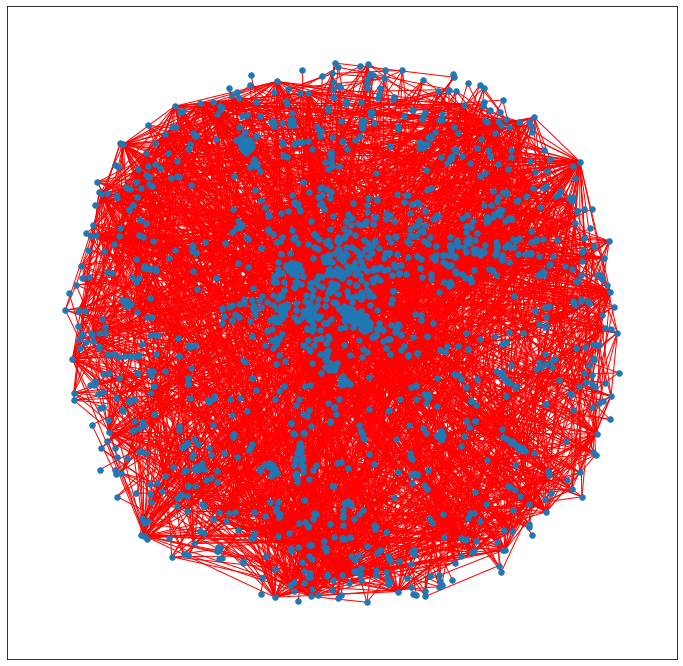

In [29]:

plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='r')
plt.show()

#### 2. Treinamento de modelo

##### 2.1. NBNE

Agora vamos trabalhar no treinamento dos modelos. Primeiro iremos aproveitar que conseguimos processar e transformar as interações entre funcionários em um grafo no passo anterior e utilizaremos dessa estrutura como uma nova forma de representação.

Assim, iremos utilizar do algoritmo `NBNE (Neighbor Based Node Embeddings)`, um algoritmo não supervisionado que é capaz de aprender a codificar nós de um grafo em um formato de vetor. Assim, o que este algoritmo faz é aprender a codificar um nó em um embedding. Cada embedding possui um certo número de dimensões que representam abstratamente características do nó, ou seja, são diretamente afetados por como é a vizinhança do mesmo e que tipo de relação ele possuía com seus vizinhos (diretamente afetado por como o funcionário desempenha com seus colegas de equipe).

Assim, agora iremos obter a representação dos nossos nós, ou seja, de cada funcionário. Inicialmente vamos fazer cada embedding ter 128 dimensões.

In [30]:
from nbne import train_model
from os.path import exists

NBNE_DIM = 128
NBNE_FILE = f"./data/out/nbne-{NBNE_DIM}.out"

# Just verify if the file isn't already instantiated (avoid repeated work)
if not exists(NBNE_FILE):
    train_model(graph=G, num_permutations=5, embedding_dimension=128, output_file=NBNE_FILE)

Esta operação nos garantiu um arquivo que armazena os embeddings de todos os nossos funcionários. Este dado será o nosso dado de entrada para os futuros algoritmos de predição. Assim, vamos recuperar este dado e armazená-lo em um formato que nos permita acessar rapidamente cada funcionário e sua representação.

In [31]:
from typing import Dict

# A hash map mapping workers registration ID to their embedding vector
funcs : Dict[int, np.array] = {}

with open(NBNE_FILE, mode="r") as file:
    lines = file.readlines()
    
    # For each worker
    for line in lines[1:]:
        data = line.split(" ")
        # Each worker, mapped by its ID stores its embedding
        funcs[int(data[0])] = np.array(data[1:]).astype(np.float64)

# Stores all the workers registration IDs
funcsID = list(funcs.keys())

Agora iremos reconstruir o grafo em formato de dataframe (que será utilizado na parte de `link prediction`). Este dataframe terá as seguintes colunas:
- $ 2 \times NBNE_{DIM} $ colunas, onde $ NBNE_{DIM} $ é o número de dimensões do embedding. Essas colunas representarão a concatenação do embedding de 2 funcionários que já trabalharam juntos, ou seja, que possuem uma aresta no grafo.
- Mais uma coluna, que será a label do nosso dado. Nesta coluna estará o valor do peso da aresta entre esses 2 nós, ou seja, o quão bom foi o desempenho entre 2 funcionários.

Iremos adicionar 2 colunas extras, porém estas não serão utilizadas no treinamento, mas sim apenas para fatores de debugging. Essas duas colunas irão armazenas o identificador dos funcionários que estão sendo representados por estes embeddings.

Observe que estamos, para cada aresta no grafo, criando 2 instâncias do dado. O modelo deve ser capaz de detectar que a dupla (a,b) tem label y, mas também que a dupla (b,a) também deve ter label y, afinal se trata de uma relação bidirecional entre os indivíduos.

In [32]:
RELATIONS_FILE = f"./data/out/relations-{NBNE_DIM}.csv"

def writeArrInCsv(arr: np.array, file, sep: str):
    for el in arr:
        file.write(f"{el}{sep}")

# If the file doesn't exists, creates it
if not exists(RELATIONS_FILE):
    with open(RELATIONS_FILE, "w+") as file:
        # Writes the column names of the data
        file.write("id1,id2,")
        for i in range(NBNE_DIM): file.write(f"a{i},")
        for i in range(NBNE_DIM): file.write(f"b{i},")
        file.write("quality\n")

        # For each worker interaction in the graph
        edges = G.edges()
        for edge in edges:
            file.write(f"{edge[0]},{edge[1]},")
            writeArrInCsv(funcs[edge[0]], file, sep=",")
            writeArrInCsv(funcs[edge[1]], file, sep=",")
            file.write(f"{G[edge[0]][edge[1]]['weight']}\n")
            # Make sure the permutation of a pair has also its own representation and label
            file.write(f"{edge[1]},{edge[0]},")
            writeArrInCsv(funcs[edge[1]], file, sep=",")
            writeArrInCsv(funcs[edge[0]], file, sep=",")
            file.write(f"{G[edge[1]][edge[0]]['weight']}\n")

# 
relations = pd.read_csv(RELATIONS_FILE, sep=",")
relations.head(4)

,id1,id2,a0,a1,a2,a3,a4,a5,a6,a7,...,b119,b120,b121,b122,b123,b124,b125,b126,b127,quality
0,10092156,10092076,0.350545,-0.167666,-0.123232,0.071500,0.311245,-0.354775,-0.084652,-0.082463,...,-0.063769,0.022796,-0.195919,-0.216960,-0.053100,0.034450,0.029280,-0.077734,-0.042138,1.0
1,10092076,10092156,0.455322,-0.217053,-0.194239,0.079115,0.392145,-0.483293,-0.132144,-0.113494,...,-0.037677,0.028224,-0.182823,-0.160727,-0.031772,0.024934,0.005268,-0.064920,-0.024334,1.0
2,10092156,10091449,0.350545,-0.167666,-0.123232,0.071500,0.311245,-0.354775,-0.084652,-0.082463,...,-0.086062,0.041781,-0.234452,-0.237607,-0.051364,0.036587,0.051155,-0.072007,-0.045309,1.0
3,10091449,10092156,0.556338,-0.244211,-0.211377,0.136215,0.507850,-0.571988,-0.139406,-0.148869,...,-0.037677,0.028224,-0.182823,-0.160727,-0.031772,0.024934,0.005268,-0.064920,-0.024334,1.0


Vamos observar então os dados de qualidade das duplas de funcionários.

Após a normalização vemos que os dados estão mais consistentes e em um range reduzido, o que facilitará a vida do algoritmo. Note que `1` é o valor máximo para o quanto dois funcionários deveriam trabalhar e `-1` para o quanto eles não deveriam trabalhar juntos. Note então que valores mais próximos de `0` indicam um alto grau de incerteza, ou seja, a predição é tão boa quanto jogar uma moeda ao ar para decidir se uma dupla deveria ou não trabalhar. 

In [33]:
relations[['id1', 'id2', 'quality']]['quality'].unique()

array([ 1.        ,  0.33333333,  0.        ,  0.2       ,  0.5       ,
        0.66666667, -1.        , -0.33333333,  0.6       ,  0.8       ,
        0.63636364,  0.81818182, -0.42857143,  0.88888889, -0.6       ,
       -0.5       ,  0.97297297, -0.77777778,  0.55555556, -0.83333333,
        0.42857143])

Se observamos, a distribuição dos valores que está no gráfico a seguir, vemos que a maioria dos valores estão concentrados em `+1` e `-1`. Assim, sabemos que nosso modelo será mais preciso para esses valores exatos.

(array([2.550e+03, 4.000e+00, 1.000e+01, 2.000e+01, 0.000e+00, 2.160e+02,
        1.080e+02, 3.200e+01, 1.000e+01, 9.036e+03]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

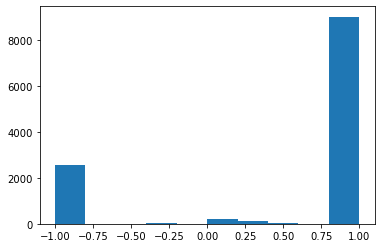

In [34]:
plt.hist(relations['quality'], align='mid')

##### 2.2. Visualização de dados

Apenas uma pequena seção com funções que irão nos auxiliar a visualizar os dados e os treinos.

In [35]:
import matplotlib.pyplot as plt

def plotTrainVal(evals, subplot, metric):
    subplot.set_title(f"Model training with '{metric}' metric")
    subplot.set_xlabel("Number of iterations")
    subplot.set_ylabel("Error")
    subplot.yaxis.grid(color='#777', alpha=0.45,linestyle='dashed')
    subplot.xaxis.grid(color='#777', alpha=0.45,linestyle='dashed')
    
    for key in evals:
        hist = evals[key][metric]
        subplot.plot(range(len(hist)), hist, label=f"{'train' if key == 'training' else 'test'}")
    subplot.legend()

def plotTrain(evals, title: str, evalMetrics: list[str]):
    outer = plt.figure(figsize=(13, 13))
    outer.suptitle(f"{title}", fontsize=16)
    subplots = outer.subplots(len(evalMetrics), 1)
    # outer.tight_layout()
    plt.subplots_adjust(hspace=0.3)
        
    i = 0
    for metric in evalMetrics:
        # Plots each validation
        plotTrainVal(evals, subplots[i], metric)
        i += 1
        
    plt.plot()

##### 2.3. Link prediction

Com todos esses dados em mãos, podemos finalmente começar a treinar modelos que fazem predições a respeito de algo em função de nossos funcionários. Primeiramente iremos treinar um modelo que aprenda a nos dizer o quão bom será o desempenho de uma dupla caso ambos trabalhem juntos.

Para este caso iremos dar o nome de `Link Prediction`, pois o que este algoritmo fará é prever qual será o peso da aresta que liga dois nós. Abstratamente, o que este algoritmo fará é tentar prever o quão bom será o desempenho de dois funcionários caso trabalhem juntas.

Deste modo, se torna claro que precisaremos utilizar de um algoritmo de `regressão` para fazer tais predições, afinal a label do nosso projeto é um número contínuo. Para isto utilizaremos do `LightGBM`, que utiliza de um algoritmo de boosting como arquitetura de seus modelos. Assim, o que este algoritmo irá fazer é construir uma certa quantidade de árvores relativamente "simples" e juntar as predições de todas elas para produzir um resultado final. Este algoritmo é bom não apenas pela sua resistência ao overfitting (quando seus parâmetros são utilizados de maneira sábia), mas também pela sua simplicidade de treinamento e uso.

Os valores a seguir de parâmetros como `learning rate (0.05)`, `número de árvores (256)`, `máxima profundidade das árvores`, `métricas de validação` e afins foram todos obtidos após diversos testes e experimentos feitos com os dados. Assim, esses valores foram os que mostraram melhor resultado.

In [41]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import joblib
import random

# Function that trains an lightgbm regressor for link prediction. It takes:
# 
def trainLinkPrediction(n_estimators: int, metrics: list[str], file: str, l_rate = 0.05):
    # Defines the model
    model : lgb.LGBMRegressor = lgb.LGBMRegressor(
        learning_rate = l_rate,
        n_estimators = n_estimators,
    )
    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        relations.drop(['id1', 'id2', 'quality'], axis=1), 
        relations['quality'], 
        test_size=0.3
    )

    evals = {}
    # Trains the model
    model.fit(x_train, 
              y_train,
              eval_set = [(x_train, y_train), (x_test, y_test)],
              eval_metric = metrics,
              callbacks = [lgb.record_evaluation(evals), 
                        #    lgb.early_stopping(50)
                           ],
              )
    # Saves the model in the file
    joblib.dump(model, file)
    return model, evals

# Loads a pre-trained model from disk. The file path should be specified
def loadModel(file: str):
    return joblib.load(file)

In [39]:
EVAL_METRICS = ['average_precision', 'l1', 'l2']
NUM_TREES = int(NBNE_DIM * 2)
MODEL_NAME = f'./data/models/nbne{NBNE_DIM}-tree{NUM_TREES}.pkl'

model, evals = trainLinkPrediction(NUM_TREES, EVAL_METRICS, MODEL_NAME)

A seguir está apresentado o resultado das validações feitas sobre o modelo treinado. Vemos que tanto a precisão como os erros de validação/teste se aproximam muito bem dos valores obtidos no treino. Isto é facilmente justificável quando retomamos à teoria aprendida em sala, na qual modelos de boosting, por serem compostos por modelos mais simples, tendem a reduzir os erros de variância e o overfitting.

Durante os experimentos empíricos foram testados valores muito mais altos de estimadores (número de árvores) e foi notado que mesmo aumentando o número de árvores o overfitting não ocorria, o que só comprovou a teoria vista em sala de aula.

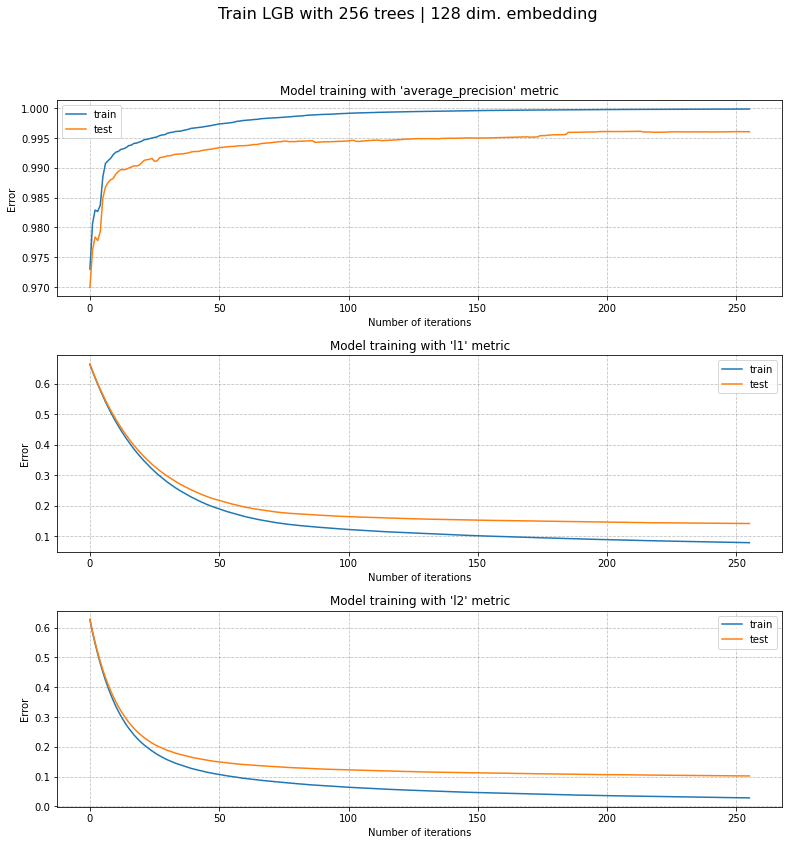

In [40]:
plotTrain(evals, f"Train LGB with {NUM_TREES} trees | {NBNE_DIM} dim. embedding", EVAL_METRICS)

Vamos definir uma função que faz uma predição de desempenho dado uma certa dupla e outro para a predição de uma dupla aleatória em nosso data set.

In [42]:
# Predicts a pair quality by using a certain model. The pairs don't need to be an 
#  existing pair (don't need to be instantiated in the relations data frame)
def predictPairQuality(id1: int, id2: int, model):
    embedding1 = funcs[id1].reshape(1, -1)
    embedding2 = funcs[id2].reshape(1, -1)
    # Predicts based on this data
    return model.predict(np.concatenate((embedding1, embedding2), axis=1))[0]

# Predicts the quality of an random, but existing, pair quality in a way we can 
#  compare the predicted value and the original value.
def predictRandomExistingPairQuality():
    example = relations.sample(n=1)
    prediction = predictPairQuality(example['id1'].iloc[0], example['id2'].iloc[0], model)
    print(f"Label: {example['quality'].iloc[0]} | Predicted: {prediction}")
    

In [43]:
# Gets 2 different random workers
rndWorkers = random.sample(funcsID, 2)
# Predicts
predictPairQuality(rndWorkers[0], rndWorkers[1], model)

0.5863911738315821

In [44]:
predictRandomExistingPairQuality()

Label: 1.0 | Predicted: 0.9545443833955077


#### 3. Resultado e uso de modelo

##### 3.1. Qualidade de equipes

Agora vamos utilizar das funções e do modelo gerado na seção anterior para tirarmos aproveito do que foi aprendido em cima de nossos dados. Primeiro vamos criar uma função que avalia a qualidade de um dado time, em que o time é uma lista de funcionários não repetidos.

<img src="./data/imgs/team_qual.png" height=300/> 

Porém, primeiramente precisamos saber como mensurar a qualidade de um dado time. Iremos estabelecer que a qualidade é definida por 
$$ 
Q = \cfrac{1}{N!} \sum_{\substack{
   0 \le i < j \le N \\
  }} 
 W_{ij}
$$

Note que o que está sendo feito é, na realidade, somando-se os pesos de todas as arestas somente uma vez e então dividindo esta soma pelo número de arestas que temos. Assim, conseguimos uma métrica "normalizada", ou melhor, uma métrica que representa o comportamento médio de uma interação neste grafo.

Note também que o valor da qualidade de equipes seguirá o mesmo domínio da qualidade de pares de funcionários, ou seja, entre 1 e -1. Obviamente por se tratar de um modelo regressivo, podemos ter valores que extarpolem estes limites, mas a relação de 1 (ser o melhor nível de sintonia entre as pessoas) e -1 (o menor nível de sintonia) se mantem.

In [ ]:
# Function that predicts the quality of a team using an certain model
def predictTeamQuality(team: list[int], model):
    teamSize = len(team)
    numEdges = 0
    T = nx.Graph()
    accQuality = np.float64(0)

    #
    for i in range(teamSize):
        _from = team[i]
        
        for j in range(i + 1, teamSize):
            to = team[j]
            curQuality = predictPairQuality(team[i], team[j], model)
            accQuality += curQuality
            numEdges += 1
            
            T.add_edge(_from, to, weight=curQuality)

    return accQuality / numEdges, T

def plotTeam(tGraph: nx.Graph, printLabel = True, decimal=6, size=(8,8)):
    plt.figure(3,figsize=size)

    pos = nx.spring_layout(tGraph)
    nx.draw(tGraph, pos)
    
    if printLabel:
        node_labels = {x: x for x in list(tGraph.nodes)}
        nx.draw_networkx_labels(tGraph, pos, labels = node_labels)
    edge_labels = nx.get_edge_attributes(tGraph,'weight')
    edge_labels = {x: np.round(edge_labels[x], decimals=decimal) for x in edge_labels.keys()}
    nx.draw_networkx_edge_labels(tGraph, pos, edge_labels = edge_labels)
    plt.show()

Se pegarmos 4 pessoas aleatórias diferentes e fizermos uma predição usando o modelo, podemos obter uma qualidade esperada do time.

In [ ]:
randomTeam =  random.sample(funcsID, 4)
quality, T = predictTeamQuality(randomTeam, model)
print(f"Team's quality: {quality}")

O grafo abaixo mostra o time criado, onde cada as labels de cada nó mostram o identificador do funcionário e cada número nas arestas a qualidade da dupla de funcionários que esta aresta liga.

In [ ]:
plotTeam(T, decimal=4, size=(7,3))

Agora vamos pegar um grupo com `score` baixo.

In [ ]:
badTeam = [10049056, 10082603, 10061063, 10076425]
quality, T = predictTeamQuality(badTeam, model)
print(f"Team's quality: {quality}")
plotTeam(T, decimal=4, size=(7,3))

Se observarmos bem, vemos que metade das arestas tem valores negativos (cada uma dessas duplas negativas não trabalham bem juntas) e a outra metade positiva. Como temos 3 arestas de cada "tipo", vemos que o score total negativo se deu muito pela aresta entre `10061063` e `10049056`, que possui um valor muito negativo.

Se pensarmos bem podemos concluir que, por este valor por ser um outlier entre os valores negativos, tivemos um offset no resultado final. Porém isto faz todo o sentido, afinal estamos lidando com uma equipe pequena e, portanto, o desempenho de uma dupla afeta bastante no resultado final da equipe. Se esse mesmo outlier ocorresse em uma equipe de 50 pessoas, este teria um efeito muito menor na equipe. Isto também faz total sentido, afinal o resultado de uma equipe dificilmente passa somente por 1 pessoa (considerando que as pessoas tem o mesmo nível hierarquico dentro do time).

Outro fato interessante que podemos extrair desse grafo é o fato de o funcionário `10076425` (nó do meio) ter desempenhos positivos com todos os outros colegas. Diferentemente de seus outros colegas, que so desempenham bem quando estão trabalhando com `10076425`, ele é capaz de desemepnhar bem com todos os outros. Isto pode ser forte indicador de que este é um bom funcionário no geral.

Considere uma possível métrica `score do funcionário`, sendo esta métrica a soma de todos os pesos das arestas que ligam este aos seus colegas, em dada equipe. Então, um `score` positivo indica que ele desemepnha bem com grande parte de seus colegas e `negativo` desempenha mal.

Assim, podemos propor uma hipotese que poderia ser testada em projetos futuros, onde tentamos fazer uma indução direta entre o `score` total do funcionário e o quão bom este é.

#### 4. Conclusão

Data augmentation
